In [56]:
# Important: We are using PIL to read .png files later.
# This was done on purpose to read indexed png files
# in a special way -- only indexes and not map the indexes
# to actual rgb values. This is specific to PASCAL VOC
# dataset data. If you don't want thit type of behaviour
# consider using skimage.io.imread()
%reset
from PIL import Image
import numpy as np
import skimage.io as io
import tensorflow as tf
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
import os
import glob
import math
from random import shuffle
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import scipy

%matplotlib inline
import skimage.io as io

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [57]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    gray = gray.astype(np.uint8)
    return gray

In [58]:
#### Get data paths
imageFolder = '/home/kristoffer/Documents/data/synthetic2_128x128'
imgPath = os.path.realpath(imageFolder)
trainingPath = os.path.join(os.path.dirname(imgPath), imageFolder + os.sep + "training")
validationPath = os.path.join(os.path.dirname(imgPath), imageFolder + os.sep + "validation")
print(trainingPath)
print(validationPath)

trainingFolderList = os.listdir(trainingPath)
validationFolderList = os.listdir(validationPath)


/home/kristoffer/Documents/data/synthetic2_128x128/training
/home/kristoffer/Documents/data/synthetic2_128x128/validation


In [80]:
#### Flag for Ball or NoBall
#ballFlag 0: Only no ball images, 1: Only ball images, 2: Both ball and no ball images
ballFlag = 2

if ballFlag == 0:
    trainingImagePaths = glob.glob(trainingPath+os.sep+"**"+os.sep+"*0.png", recursive=True)
    validationImagePaths = glob.glob(validationPath+os.sep+"**"+os.sep+"*0.png", recursive=True)
elif ballFlag == 1: 
    trainingImagePaths = glob.glob(trainingPath+os.sep+"**"+os.sep+"*1.png", recursive=True)
    validationImagePaths = glob.glob(validationPath+os.sep+"**"+os.sep+"*1.png", recursive=True)
elif ballFlag == 2:
    trainingImagePaths = glob.glob(trainingPath+os.sep+"**"+os.sep+"*.png", recursive=True)
    validationImagePaths = glob.glob(validationPath+os.sep+"**"+os.sep+"*.png", recursive=True)
    
shuffle(trainingImagePaths)
shuffle(validationImagePaths)

In [70]:
print(len(trainingImagePaths))
print(len(validationImagePaths))

95758
37758


In [71]:
aug_data_flag = False
if aug_data_flag:
    # Image augmentation
    datagen = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1, 
            shear_range=0.1,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest',
            data_format = "channels_last")
    num_img_aug = 10

    #trainingImagePaths = trainingImagePaths[0:2]


    johs_er_dyn = 0
    for img_path in trainingImagePaths:
        # Get folder path
        temp_data_name = img_path.split(os.sep)[-1]
        temp_data_name_aug = temp_data_name.split('_')[0]
        temp_folder_path = os.path.dirname(img_path)

        if (johs_er_dyn% np.round(len(trainingImagePaths)*0.01)) == 0:
            print(np.floor(johs_er_dyn/ round(len(trainingImagePaths)*0.01)))

        johs_er_dyn += 1

        img = imread(img_path)
        if img.shape == (128,128,3) and (temp_data_name_aug !='aug*'):
            aug_img = img.reshape((1,) + img.shape)  # this is a Numpy array with shape (1, 3, 150, 150)


            i = 0
            for aug_img in datagen.flow(aug_img, batch_size=1):
                aug_img = aug_img.squeeze()
                scipy.misc.imsave(temp_folder_path + os.sep + "aug_" + str(i) + "_" +  temp_data_name, aug_img)

                if i >= (num_img_aug-1):
                    break  # otherwise the generator would loop indefinitely
                i += 1



In [81]:
#### Get ball_no_ball targets from filename
def get_ball_no_ball_data_from_path(path_names, num_samples):
    
    targetIsBall = np.empty([len(path_names),1], dtype=np.uint8)
    
    for ii in range(len(path_names)):
        temp = path_names[ii].split('.')[0]
        targetIsBall[ii] = int(temp[-1]) 

    # Find minimum number of ball noball
    min_num_samples = 2*min(np.sum(targetIsBall),len(targetIsBall)-np.sum(targetIsBall))
    num_samples = np.uint32(min(min_num_samples,num_samples))

    targetIsBallOut = np.empty([num_samples,1], dtype=np.uint8)
    targetPosBallOut = np.empty([num_samples,2], dtype=np.uint8)
    pathNameOut = []
    
    samples_ball = 0
    samples_noball = 0
    ii = 0
    idx_out = 0
    
    while (samples_ball < math.ceil(num_samples/2.0) or samples_noball < math.floor(num_samples/2.0)):
        temp = path_names[ii].split(os.sep)[-1]
        temp = temp.split("_")
        temp = [int(temp[-3]), int(temp[-2])]
        if (targetIsBall[ii] == 1 and samples_ball < math.ceil(num_samples/2.0)):
            samples_ball = samples_ball + 1
            targetIsBallOut[idx_out] = 1
            targetPosBallOut[idx_out] = temp
            pathNameOut.append(path_names[ii])
            idx_out = idx_out + 1
        elif (targetIsBall[ii] == 0 and samples_noball < math.floor(num_samples/2.0)):
            samples_noball = samples_noball + 1
            targetIsBallOut[idx_out] = 0
            targetPosBallOut[idx_out] = [int(0), int(0)]
            pathNameOut.append(path_names[ii])
            idx_out = idx_out + 1
            
        ii = ii +1
    
    permutation = np.random.permutation(num_samples)
    pathNameOut = np.asarray(pathNameOut)
    pathNameOut = pathNameOut[permutation]
    pathNameOut = pathNameOut.tolist()
        
    return pathNameOut, targetPosBallOut[permutation], targetIsBallOut[permutation]
    #mix a paths der er equal ball no ball
    
#### Get ball_pos targets from filename
def get_ball_pos_data_from_path(path_names, num_samples):
    
    targetIsBall = np.empty([len(path_names),1], dtype=np.uint8)
    
    for ii in range(len(path_names)):
        temp = path_names[ii].split('.')[0]
        targetIsBall[ii] = int(temp[-1]) 

    # Find minimum number of ball noball
    min_num_samples = np.sum(targetIsBall)
    num_samples = np.uint32(min(min_num_samples,num_samples))
    
    targetPosBallOut = np.empty([num_samples,2], dtype=np.uint8)
    pathNameOut = []
    
    samples_ball = 0
    ii = 0
    idx_out = 0
    
    while (samples_ball <num_samples):
        temp = path_names[ii].split(os.sep)[-1]
        temp = temp.split("_")
        temp = [int(temp[-3]), int(temp[-2])]
        
        if (targetIsBall[ii] == 1):
            samples_ball = samples_ball + 1
            targetPosBallOut[idx_out] = temp
            pathNameOut.append(path_names[ii])
            idx_out = idx_out + 1
            
        ii = ii +1
    
    permutation = np.random.permutation(num_samples)
    pathNameOut = np.asarray(pathNameOut)
    pathNameOut = pathNameOut[permutation]
    pathNameOut = pathNameOut.tolist()
        
    targetIsBallOut = np.ones([num_samples,1], dtype=np.uint8)
    
    return pathNameOut, targetPosBallOut[permutation], targetIsBallOut
    #mix a paths der er equal ball no ball

In [73]:
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [98]:
def create_tfrecords(tfrecords_filename, img_path, annotations):
    os.chdir('/media/kristoffer/DRIVE-N-GO/data_annotation_3')
    writer = tf.python_io.TFRecordWriter(tfrecords_filename)

    iter = 0
    for img_path, annotation in zip(img_path, annotations):
        iter = iter +1
        if iter%100 == 0:
            print(iter)
            
        img = imread(img_path)
        #img = rgb2gray(img) # gray image

        # The reason to store image sizes was demonstrated
        # in the previous example -- we have to know sizes
        # of images to later read raw serialized string,
        # convert to 1d array and convert to respective
        # shape that image used to have.
        img_height = img.shape[0]
        img_width = img.shape[1]
        try:     
            img_channels = img.shape[2]
        except IndexError:
            img_channels = 1
        
        annotation_width = annotation.shape[0]
        #annotation_height = annotation.shape[0]
        #annotation_width = annotation.shape[1]

        img_raw = img.tostring()
        annotation_raw = annotation.tostring()

        example = tf.train.Example(features=tf.train.Features(feature={
            'img_height': _int64_feature(img_height),
            'img_width': _int64_feature(img_width),
            'img_channels': _int64_feature(img_channels),
            'image_raw': _bytes_feature(img_raw),
      #      'annotation_height': _int64_feature(annotation_height),
            'annotation_width': _int64_feature(annotation_width),
            'annotation_raw': _bytes_feature(annotation_raw)}))

        writer.write(example.SerializeToString())
    
    writer.close()
    os.chdir('/home/kristoffer/Dropbox/DTU/Deep_learning_-_02456/wearetracking/simpleNet')

In [68]:
## Create ball no ball data

# File names for the data
training_filename = 'ballNoBall_GREY_training.tfrecords'    
validation_filename = 'ballNoBall_GREY_validation.tfrecords'    
#training_filename = 'dummy'
#validation_filename = 'dummy'

trainingImagePathsSubset, trainingTargetPosBallSubset, trainingTargetIsBallSubset = get_ball_no_ball_data_from_path(trainingImagePaths, 10000000)
validationImagePathsSubset, validationTargetPosBallSubset, validationTargetIsBallSubset = get_ball_no_ball_data_from_path(validationImagePaths, 10000000)

# Create data
create_tfrecords(training_filename, trainingImagePathsSubset, trainingTargetIsBallSubset)
create_tfrecords(validation_filename, validationImagePathsSubset, validationTargetIsBallSubset)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

133000
133100
133200
133300
133400
133500
133600
133700
133800
133900
134000
134100
134200
134300
134400
134500
134600
134700
134800
134900
135000
135100
135200
135300
135400
135500
135600
135700
135800
135900
136000
136100
136200
136300
136400
136500
136600
136700
136800
136900
137000
137100
137200
137300
137400
137500
137600
137700
137800
137900
138000
138100
138200
138300
138400
138500
138600
138700
138800
138900
139000
139100
139200
139300
139400
139500
139600
139700
139800
139900
140000
140100
140200
140300
140400
140500
140600
140700
140800
140900
141000
141100
141200
141300
141400
141500
141600
141700
141800
141900
142000
142100
142200
142300
142400
142500
142600
142700
142800
142900
143000
143100
143200
143300
143400
143500
143600
143700
143800
143900
144000
144100
144200
144300
144400
144500
144600
144700
144800
144900
145000
145100
145200
145300
145400
145500
145600
145700
145800
145900
146000
146100
146200
146300
146400
146500
146600
146700
146800
146900
147000
147100
147200

In [69]:
## Create ball position data

# File names for the data
training_filename = 'ballPos_training.tfrecords'    
validation_filename = 'ballPos_validation.tfrecords'    
#training_filename = 'dummy'
#validation_filename = 'dummy'

trainingImagePathsSubset, trainingTargetPosBallSubset, trainingTargetIsBallSubset = get_ball_pos_data_from_path(trainingImagePaths, 10000000)
validationImagePathsSubset, validationTargetPosBallSubset, validationTargetIsBallSubset = get_ball_pos_data_from_path(validationImagePaths, 10000000)

# Create data
create_tfrecords(training_filename, trainingImagePathsSubset, trainingTargetPosBallSubset)
create_tfrecords(validation_filename, validationImagePathsSubset, validationTargetPosBallSubset)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

In [99]:
## Create ball no ball and position data

# File names for the data
training_filename = 'ballNoBallAndPos_training.tfrecords'    
validation_filename = 'ballNoBallAndPos_validation.tfrecords'    
#training_filename = 'dummy'
#validation_filename = 'dummy'

# Ball no ball and pos
trainingImagePathsSubset, trainingTargetPosBallSubset, trainingTargetIsBallSubset = get_ball_no_ball_data_from_path(trainingImagePaths, 1000000)
validationImagePathsSubset, validationTargetPosBallSubset, validationTargetIsBallSubset = get_ball_no_ball_data_from_path(validationImagePaths, 1000000)

# Ball and pos
#trainingImagePathsSubset, trainingTargetPosBallSubset, trainingTargetIsBallSubset = get_ball_pos_data_from_path(trainingImagePaths, 10000000)
#validationImagePathsSubset, validationTargetPosBallSubset, validationTargetIsBallSubset = get_ball_pos_data_from_path(validationImagePaths, 10000000)

# Append targets
trainingTargetBallnoBallAndPosSubset = np.concatenate((trainingTargetIsBallSubset, trainingTargetPosBallSubset),axis=1)
validationTargetBallnoBallAndPosSubset = np.concatenate((validationTargetIsBallSubset, validationTargetPosBallSubset),axis=1)

# Create data
create_tfrecords(training_filename, trainingImagePathsSubset, trainingTargetBallnoBallAndPosSubset)
create_tfrecords(validation_filename, validationImagePathsSubset, validationTargetBallnoBallAndPosSubset)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

133000
133100
133200
133300
133400
133500
133600
133700
133800
133900
134000
134100
134200
134300
134400
134500
134600
134700
134800
134900
135000
135100
135200
135300
135400
135500
135600
135700
135800
135900
136000
136100
136200
136300
136400
136500
136600
136700
136800
136900
137000
137100
137200
137300
137400
137500
137600
137700
137800
137900
138000
138100
138200
138300
138400
138500
138600
138700
138800
138900
139000
139100
139200
139300
139400
139500
139600
139700
139800
139900
140000
140100
140200
140300
140400
140500
140600
140700
140800
140900
141000
141100
141200
141300
141400
141500
141600
141700
141800
141900
142000
142100
142200
142300
142400
142500
142600
142700
142800
142900
143000
143100
143200
143300
143400
143500
143600
143700
143800
143900
144000
144100
144200
144300
144400
144500
144600
144700
144800
144900
145000
145100
145200
145300
145400
145500
145600
145700
145800
145900
146000
146100
146200
146300
146400
146500
146600
146700
146800
146900
147000
147100
147200

### Load and validate data

In [37]:
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
IMAGE_CHANNELS = 1
ANNOTATION_WIDTH = 1

def read_and_decode(filename_queue):
    
    reader = tf.TFRecordReader()

    _, serialized_example = reader.read(filename_queue)

    features = tf.parse_single_example(
      serialized_example,
      # Defaults are not specified since both keys are required.
      features={
        'img_height': tf.FixedLenFeature([], tf.int64),
        'img_width': tf.FixedLenFeature([], tf.int64),
        'image_raw': tf.FixedLenFeature([], tf.string),
        'annotation_width': tf.FixedLenFeature([], tf.int64),  
        'annotation_raw': tf.FixedLenFeature([], tf.string)
        })

    # Convert from a scalar string tensor (whose single string has
    # length mnist.IMAGE_PIXELS) to a uint8 tensor with shape
    # [mnist.IMAGE_PIXELS].
    image = tf.decode_raw(features['image_raw'], tf.uint8)
    annotation = tf.decode_raw(features['annotation_raw'], tf.uint8)
    
    img_height = tf.cast(features['img_height'], tf.int32)
    img_width = tf.cast(features['img_width'], tf.int32)
    annotation_width = tf.cast(features['annotation_width'], tf.int32)
    
    image_shape = tf.stack([img_height, img_width, IMAGE_CHANNELS])
    annotation_shape = tf.stack([1, annotation_width, 1])
    
    image = tf.reshape(image, image_shape)
    annotation = tf.reshape(annotation, annotation_shape)

    # Random transformations can be put here: right before you crop images
    # to predefined size. To get more information look at the stackoverflow
    # question linked above.
    
    resized_image = tf.image.resize_image_with_crop_or_pad(image=image,
                                           target_height=IMAGE_HEIGHT,
                                           target_width=IMAGE_WIDTH)
    
    resized_annotation = tf.image.resize_image_with_crop_or_pad(image=annotation,
                                           target_height=1,
                                           target_width=ANNOTATION_WIDTH)
    
    
    images, annotations = tf.train.shuffle_batch( [resized_image, resized_annotation],
                                                 batch_size=4,
                                                 capacity=1000,
                                                 num_threads=1,
                                                 min_after_dequeue=100)
    
    return images, annotations

In [38]:
tf.reset_default_graph()
image_appended = []
annotation_appended = []


#tfrecords_filename = 'ballNoBall_training.tfrecords'
tfrecords_filename = os.path.abspath("/home/kristoffer/Dropbox/DTU/Deep_learning_-_02456/wearetracking/simpleNet/ballNoBall_GREY_training.tfrecords")

filename_queue = tf.train.string_input_producer(
    [tfrecords_filename], num_epochs=10)

# Even when reading in multiple threads, share the filename
# queue.
image, annotation = read_and_decode(filename_queue)

# The op for initializing the variables.
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

with tf.Session()  as sess:
    
    sess.run(init_op)
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    # Let's read off 3 batches just for example
    for i in range(1):
    
        img, anno = sess.run([image, annotation])
        for j in range(img.shape[0]):
            image_appended.append(img[j,:,:,:])
            #annotation_appended.append(anno)
    coord.request_stop()
    coord.join(threads)

INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.InvalidArgumentError'>, Input to reshape is a tensor with 131072 values, but the requested shape has 16384
	 [[Node: Reshape = Reshape[T=DT_UINT8, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/cpu:0"](DecodeRaw, stack)]]


INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.InvalidArgumentError'>, Input to reshape is a tensor with 131072 values, but the requested shape has 16384
	 [[Node: Reshape = Reshape[T=DT_UINT8, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/cpu:0"](DecodeRaw, stack)]]


OutOfRangeError: RandomShuffleQueue '_4_shuffle_batch/random_shuffle_queue' is closed and has insufficient elements (requested 4, current size 0)
	 [[Node: shuffle_batch = QueueDequeueManyV2[component_types=[DT_UINT8, DT_UINT8], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](shuffle_batch/random_shuffle_queue, shuffle_batch/n)]]

Caused by op 'shuffle_batch', defined at:
  File "/home/kristoffer/anaconda3/envs/tensorflow/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kristoffer/anaconda3/envs/tensorflow/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kristoffer/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/kristoffer/anaconda3/envs/tensorflow/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/kristoffer/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/kristoffer/anaconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/kristoffer/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/kristoffer/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/kristoffer/anaconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/kristoffer/anaconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/kristoffer/anaconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/kristoffer/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/kristoffer/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/kristoffer/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/kristoffer/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/kristoffer/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/kristoffer/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/kristoffer/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/kristoffer/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/kristoffer/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-38-869f49dc8203>", line 14, in <module>
    image, annotation = read_and_decode(filename_queue)
  File "<ipython-input-37-5810036ff99e>", line 56, in read_and_decode
    min_after_dequeue=100)
  File "/home/kristoffer/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/training/input.py", line 1220, in shuffle_batch
    name=name)
  File "/home/kristoffer/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/training/input.py", line 791, in _shuffle_batch
    dequeued = queue.dequeue_many(batch_size, name=name)
  File "/home/kristoffer/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/data_flow_ops.py", line 457, in dequeue_many
    self._queue_ref, n=n, component_types=self._dtypes, name=name)
  File "/home/kristoffer/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/gen_data_flow_ops.py", line 1342, in _queue_dequeue_many_v2
    timeout_ms=timeout_ms, name=name)
  File "/home/kristoffer/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/kristoffer/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/kristoffer/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

OutOfRangeError (see above for traceback): RandomShuffleQueue '_4_shuffle_batch/random_shuffle_queue' is closed and has insufficient elements (requested 4, current size 0)
	 [[Node: shuffle_batch = QueueDequeueManyV2[component_types=[DT_UINT8, DT_UINT8], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](shuffle_batch/random_shuffle_queue, shuffle_batch/n)]]


In [34]:
fig = plt.figure(figsize=(50, 50))
for idx in range(len(image_appended)):
    plt.subplot(10, 10, idx + 1)
    image = image_appended[idx]
    plt.imshow(image)
    plt.axis('off')
plt.show()

print(anno)

[[[[56]
   [45]]]


 [[[21]
   [93]]]


 [[[75]
   [28]]]


 [[[72]
   [33]]]]


## MNIST DATA LOADER

In [5]:
from tensorflow.examples.tutorials.mnist import input_data

mnist_data = input_data.read_data_sets('MNIST_data', 
                                       one_hot=False,   # Convert the labels into one hot encoding
                                       dtype='float32', # rescale images to `[0, 1]`
                                       reshape=False, # Don't flatten the images to vectors
                                      )




Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [7]:
# Get 0 and 1 images and labels
training_mnist_images = []
training_mnist_labels = []
validation_mnist_images = []
validation_mnist_labels = []


# Find index
for ii in range(len(mnist_data.train.labels)):
    if (mnist_data.train.labels[ii] == 0 or mnist_data.train.labels[ii] == 1):
        training_mnist_images.append(np.uint8(np.round(mnist_data.train.images[ii]*255)))
        training_mnist_labels.append(mnist_data.train.labels[ii])
# Find index
for ii in range(len(mnist_data.test.labels)):
    if (mnist_data.test.labels[ii] == 0 or mnist_data.test.labels[ii] == 1):
        validation_mnist_images.append(np.uint8(np.round(mnist_data.test.images[ii]*255)))
        validation_mnist_labels.append(mnist_data.test.labels[ii])
         
shuffle(validation_mnist_labels)

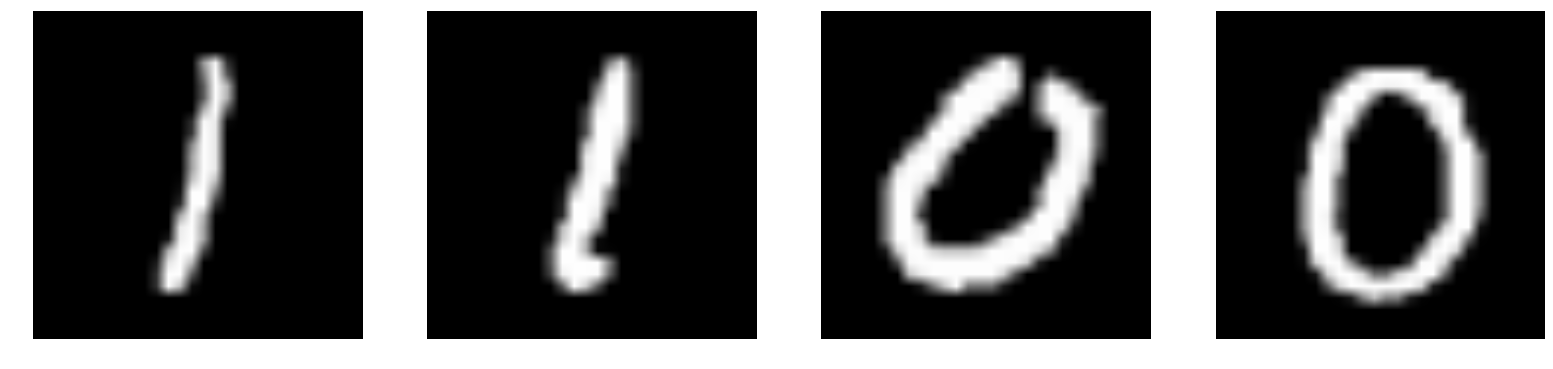

In [8]:
## Plot mnist examples

fig = plt.figure(figsize=(50, 50))
for idx in range(4):
    plt.subplot(10, 10, idx + 1)
    image = np.squeeze(training_mnist_images[idx])
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.show()

In [9]:
def create_tfrecords_mnist(tfrecords_filename, mnist_images, mnist_labels):
    writer = tf.python_io.TFRecordWriter(tfrecords_filename)

    iter = 0
    for ii in range(len(mnist_labels)):
        iter = iter +1
        if iter%100 == 0:
            print(iter)
            
        img = mnist_images[ii]

        # The reason to store image sizes was demonstrated
        # in the previous example -- we have to know sizes
        # of images to later read raw serialized string,
        # convert to 1d array and convert to respective
        # shape that image used to have.
        img_height = img.shape[0]
        img_width = img.shape[1]
        img_channels = 1#img.shape[2]
        annotation_width = 1
        #annotation_height = annotation.shape[0]
        #annotation_width = annotation.shape[1]

        img_raw = img.tostring()
        annotation_raw = mnist_labels[ii].tostring()

        example = tf.train.Example(features=tf.train.Features(feature={
            'img_height': _int64_feature(img_height),
            'img_width': _int64_feature(img_width),
            'img_channels': _int64_feature(img_channels),
            'image_raw': _bytes_feature(img_raw),
      #      'annotation_height': _int64_feature(annotation_height),
            'annotation_width': _int64_feature(annotation_width),
            'annotation_raw': _bytes_feature(annotation_raw)}))

        writer.write(example.SerializeToString())
    
    writer.close()

# File names for the data
training_filename = 'mnist_zero_one_training.tfrecords'    
validation_filename = 'mnist_zero_one_validation.tfrecords'    
#training_filename = 'dummy'
#validation_filename = 'dummy'


# Create data
create_tfrecords_mnist(training_filename, training_mnist_images, training_mnist_labels)
create_tfrecords_mnist(validation_filename, validation_mnist_images, validation_mnist_labels)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100


In [10]:
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
ANNOTATION_WIDTH = 1

def read_and_decode(filename_queue):
    
    reader = tf.TFRecordReader()

    _, serialized_example = reader.read(filename_queue)

    features = tf.parse_single_example(
      serialized_example,
      # Defaults are not specified since both keys are required.
      features={
        'img_height': tf.FixedLenFeature([], tf.int64),
        'img_width': tf.FixedLenFeature([], tf.int64),
        'image_raw': tf.FixedLenFeature([], tf.string),
        'annotation_width': tf.FixedLenFeature([], tf.int64),  
        'annotation_raw': tf.FixedLenFeature([], tf.string)
        })

    # Convert from a scalar string tensor (whose single string has
    # length mnist.IMAGE_PIXELS) to a uint8 tensor with shape
    # [mnist.IMAGE_PIXELS].
    image = tf.decode_raw(features['image_raw'], tf.uint8)
    annotation = tf.decode_raw(features['annotation_raw'], tf.uint8)
    
    img_height = tf.cast(features['img_height'], tf.int32)
    img_width = tf.cast(features['img_width'], tf.int32)
    annotation_width = tf.cast(features['annotation_width'], tf.int32)
    
    image_shape = tf.stack([img_height, img_width, 1])
    annotation_shape = tf.stack([1, annotation_width, 1])
    
    image = tf.reshape(image, image_shape)
    annotation = tf.reshape(annotation, annotation_shape)

    # Random transformations can be put here: right before you crop images
    # to predefined size. To get more information look at the stackoverflow
    # question linked above.
    
    resized_image = tf.image.resize_image_with_crop_or_pad(image=image,
                                           target_height=IMAGE_HEIGHT,
                                           target_width=IMAGE_WIDTH)
    
    resized_annotation = tf.image.resize_image_with_crop_or_pad(image=annotation,
                                           target_height=1,
                                           target_width=ANNOTATION_WIDTH)
    
    
    images, annotations = tf.train.shuffle_batch( [resized_image, resized_annotation],
                                                 batch_size=10,
                                                 capacity=1000,
                                                 num_threads=1,
                                                 min_after_dequeue=100)
    
    return images, annotations

In [12]:
tf.reset_default_graph()
image_appended = []

#tfrecords_filename = 'ballNoBall_training.tfrecords'
tfrecords_filename = os.path.abspath("C:\\Users\\Goble\\Documents\\data\\mnist_zero_one_training.tfrecords")

filename_queue = tf.train.string_input_producer(
    [tfrecords_filename], num_epochs=10)

# Even when reading in multiple threads, share the filename
# queue.
image, annotation = read_and_decode(filename_queue)

# The op for initializing the variables.
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

with tf.Session()  as sess:
    
    sess.run(init_op)
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    # Let's read off 3 batches just for example
    for i in range(10):
    
        img, anno = sess.run([image, annotation])
        for j in range(img.shape[0]):
            image_appended.append(img[j,:,:,:])
    coord.request_stop()
    coord.join(threads)

# Loader for TAXs ball no ball example

In [60]:
#### Get data paths
imageFolder = 'C:\\Users\\Goble\\Documents\\data\\ballnoball2\\ballnoball'
imgPath = os.path.realpath(imageFolder)
trainingPath = os.path.join(os.path.dirname(imgPath), imageFolder + os.sep + "training")
validationPath = os.path.join(os.path.dirname(imgPath), imageFolder + os.sep + "validation")
print(trainingPath)
print(validationPath)

trainingFolderList = os.listdir(trainingPath)
validationFolderList = os.listdir(validationPath)


C:\Users\Goble\Documents\data\ballnoball2\ballnoball\training
C:\Users\Goble\Documents\data\ballnoball2\ballnoball\validation


In [61]:
trainingImagePaths = glob.glob(trainingPath+os.sep+"**"+os.sep+"*.png", recursive=True)
validationImagePaths = glob.glob(validationPath+os.sep+"**"+os.sep+"*.png", recursive=True)
    
shuffle(trainingImagePaths)
shuffle(validationImagePaths)



In [62]:
#### Get targets from filename


def get_data_from_path(path_names, num_samples):
    
    targetIsBall = np.empty([len(path_names),1], dtype=np.uint8)
    
    for ii in range(len(path_names)):
        temp = path_names[ii].split('\\')[-2]
        if set(temp) ==  set('ball'):
            targetIsBall[ii] = 1 
        else:
            targetIsBall[ii] = 0
        
            
    # Find minimum number of ball noball
    min_num_samples = min(np.sum(targetIsBall),len(targetIsBall)-np.sum(targetIsBall))
    num_samples = min(min_num_samples,num_samples)
    
    targetIsBallOut = np.empty([num_samples,1], dtype=np.uint8)
    pathNameOut = []
    
    samples_ball = 0
    samples_noball = 0
    ii = 0
    idx_out = 0
    
    while (samples_ball < math.ceil(num_samples/2.0) or samples_noball < math.floor(num_samples/2.0)):
        if (targetIsBall[ii] == 1 and samples_ball < math.ceil(num_samples/2.0)):
            samples_ball = samples_ball + 1
            targetIsBallOut[idx_out] = 1
            pathNameOut.append(path_names[ii])
            idx_out = idx_out + 1
        elif (targetIsBall[ii] == 0 and samples_noball < math.floor(num_samples/2.0)):
            samples_noball = samples_noball + 1
            targetIsBallOut[idx_out] = 0
            pathNameOut.append(path_names[ii])
            idx_out = idx_out + 1
            
        ii = ii +1
    
    permutation = np.random.permutation(num_samples)
    pathNameOut = np.asarray(pathNameOut)
    pathNameOut = pathNameOut[permutation]
    pathNameOut = pathNameOut.tolist()
        
    return pathNameOut, targetIsBallOut[permutation]
    #mix a paths der er equal ball no ball

In [63]:
trainingImagePathsSubset, trainingTargetIsBallSubset = get_data_from_path(trainingImagePaths, 100000000)
validationImagePathsSubset, validationTargetIsBallSubset = get_data_from_path(validationImagePaths, 10000000000)

# File names for the data
training_filename = 'ballNoBallGrey_training.tfrecords'    
validation_filename = 'ballNoBallGrey_validation.tfrecords'    

# Create data
create_tfrecords(training_filename, trainingImagePathsSubset, trainingTargetIsBallSubset)
create_tfrecords(validation_filename, validationImagePathsSubset, validationTargetIsBallSubset)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850